# Dataset Truncation Modeling

In [1]:
from os.path import join
import numpy as np
import statsmodels.api as sm

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import markplotlib

In [3]:
from modules import load_xft

In [4]:
maxOverallRanks = [25, 50, 75, 100, 250, 500, 750, 1000, 1500, 2000, 2500, 3500, 5000]

In [5]:
cleandir = join("..", "data", "clean")

In [6]:
dfs = []
for maxOverallRank in maxOverallRanks:
    df = load_xft.load_competition_results(
        join(cleandir, "competition_results.parquet"), maxOverallRank
    )
    df.sort_index(inplace=True)
    dfs.append(df)

In [7]:
dfs[0].head()

divisionNumber gender  \
year competitionType workoutNumber divisionName                          
2007 games           1             Men                        1   male   
                                   Men                        1   male   
                                   Men                        1   male   
                                   Men                        1   male   
                                   Men                        1   male   

                                                   height     weight   age  \
year competitionType workoutNumber divisionName                              
2007 games           1             Men           1.680000  70.370071  33.0   
                                   Men           1.770993  81.175217  33.0   
                                   Men           1.653945  64.921913  28.0   
                                   Men           1.791580  87.436272  32.0   
                                   Men           1.832062  84.603508  30.0   

                                                 workoutRank  overallRank  \
year competitionType workoutNumber divisionName                             
2007 games           1             Men                   1.0          2.0   
                                   Men                   2.0          1.0   
                                   Men                   3.0          4.0   
                                   Men                   4.0          3.0   
                                   Men                   5.0          7.0   

                                                        r         o         h  \
year competitionType workoutNumber divisionName                                 
2007 games           1             Men           1.564726  1.186831 -1.674592   
                                   Men           1.186831  1.564726 -0.028518   
                                   Men           0.928899  0.721522 -2.145927   
                                   Men           0.721522  0.928899  0.343907   
                                   Men           0.541395  0.377392  1.076229   

                                                        w         a  
year competitionType workoutNumber divisionName                      
2007 games           1             Men          -3.009498  1.787424  
                                   Men          -1.252669  1.787424  
                                   Men          -3.895324  0.330728  
                                   Men          -0.234672  1.496085  
                                   Men          -0.695257  0.913407

In [8]:
def cutoff_regressions(ax, year, competitionType, workoutNumber, divisionName):
    coefs = []
    for df in dfs:
        sl = df.xs(key=(year, competitionType, workoutNumber, divisionName))
        sl = sl[["r", "h", "w", "a"]].dropna()
        reg = sm.OLS(sl.r.values, sl[["h", "w", "a"]].values).fit()
        coefs.append(reg.params)
    coefs = np.stack(coefs)
    ax.plot(maxOverallRanks, coefs, ".-", linewidth=0.75)
    ax.axhline(0, color="k", zorder=-1)
    ax.legend(["height", "weight", "age"])
    ax.set_xlabel("overallRank cutoff")
    ax.set_ylabel("regression coefficient")
    ax.set_title(
        f"{competitionType.title()} {year}, Workout {workoutNumber}\ndivision: {divisionName}"
    )
    return None

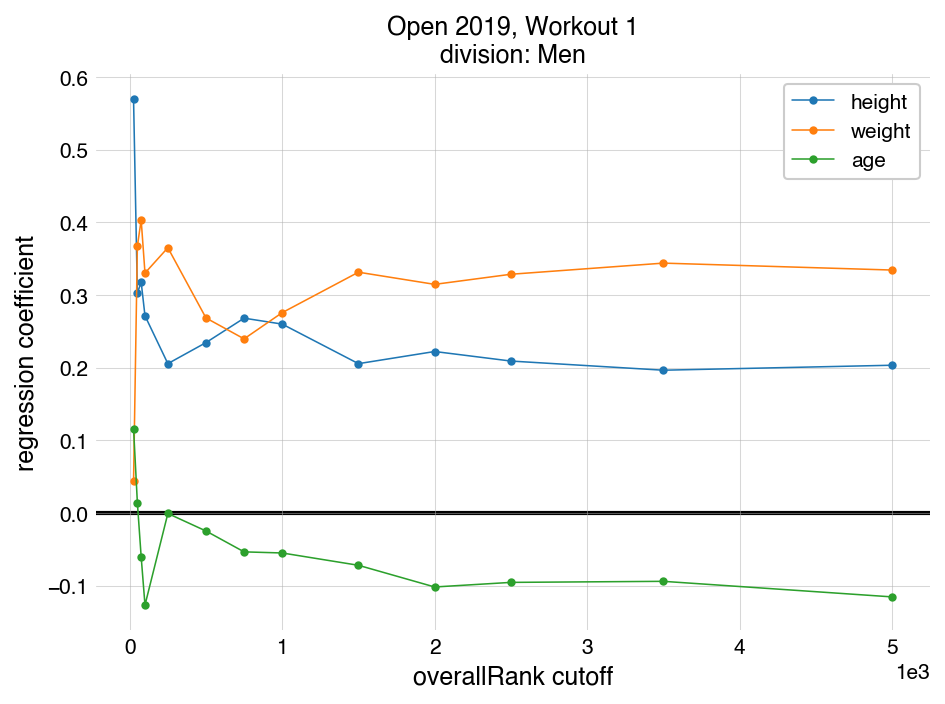

In [9]:
fig, ax = plt.subplots()
cutoff_regressions(ax, 2019, "open", 1, "Men")
fig.tight_layout()

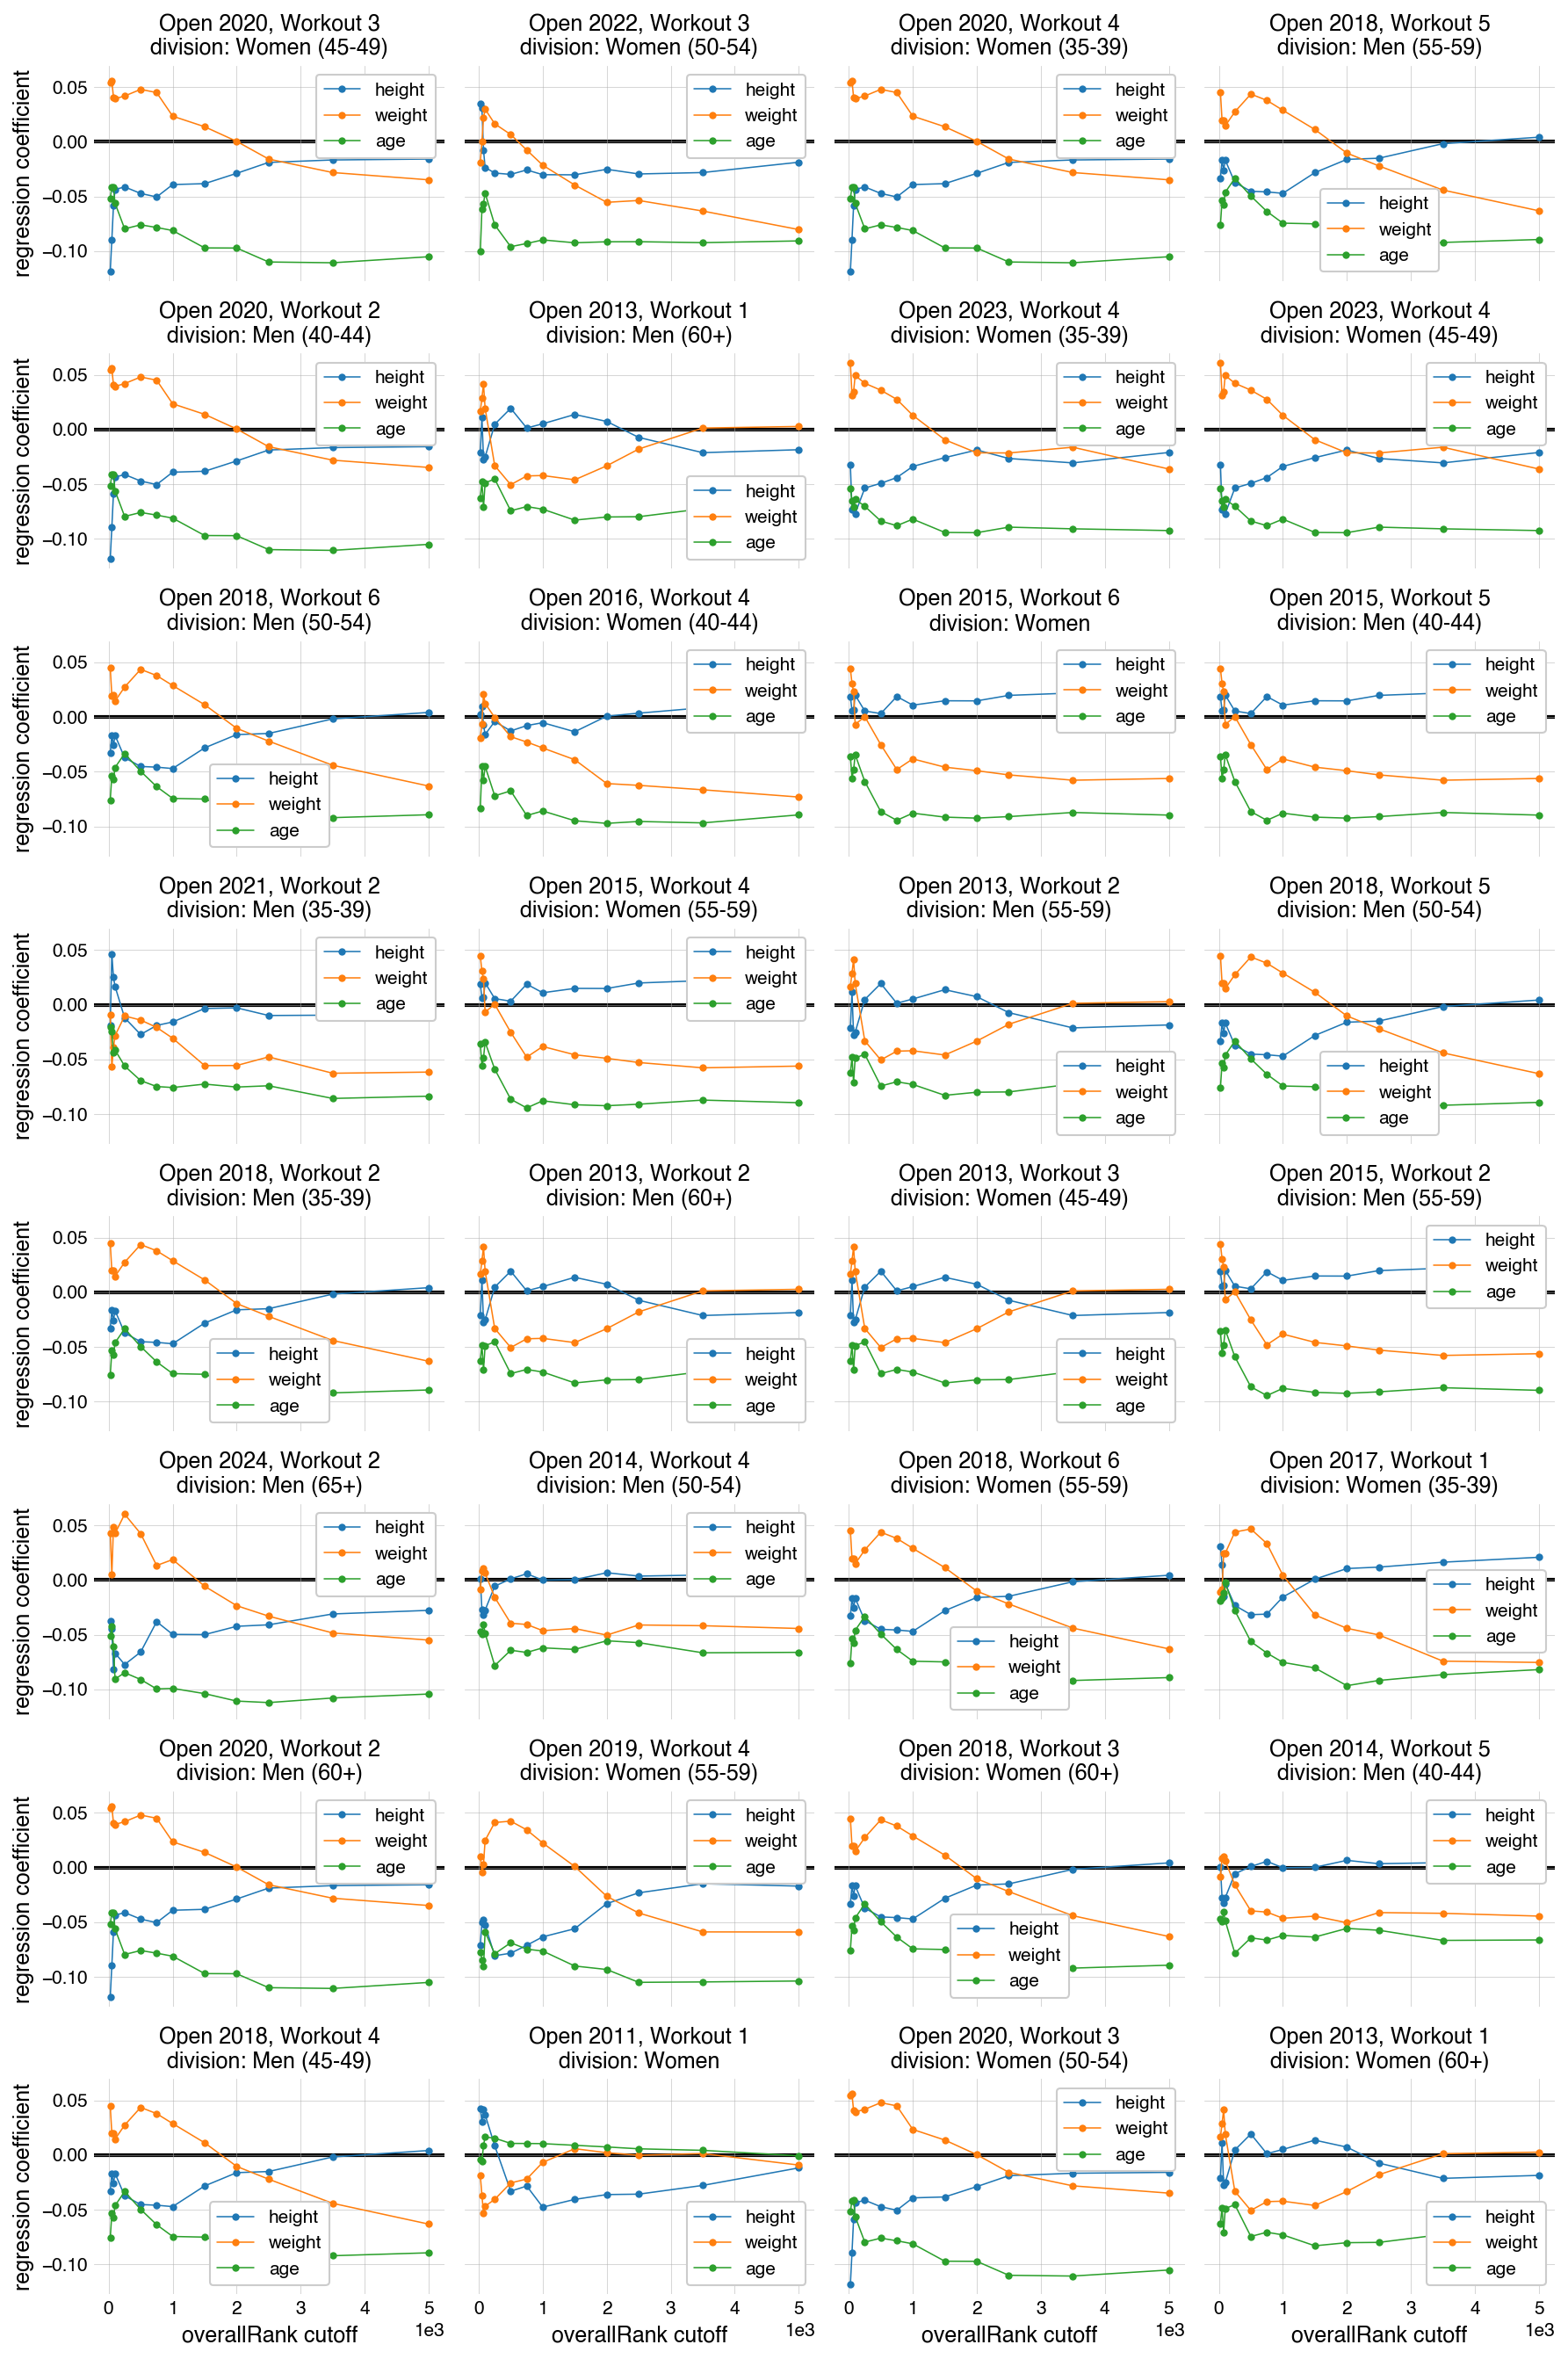

In [10]:
fig, axs = plt.subplots(8, 4, figsize=(12, 18), sharex=True, sharey=True)
keys = list(dfs[0].index)
keys = np.array(list(filter(lambda x: x[1] == "open", keys)))
keys = keys[np.random.randint(0, len(keys), size=len(axs.flatten()))]
for ax, key in zip(axs.flatten(), keys):
    cutoff_regressions(ax, *key)
for ax in axs[:-1, :].flatten():
    ax.set_xlabel(None)
for ax in axs[:, 1:].flatten():
    ax.set_ylabel(None)
fig.tight_layout()